In [1]:
# Install Kaggle API
!pip install -q kaggle

# Upload kaggle.json (download fresh from Kaggle > Account > API)
from google.colab import files
print("👉 Upload kaggle.json file (from Kaggle Account Settings)")
uploaded = files.upload()

# Move kaggle.json to the right folder
import os
os.makedirs('/root/.kaggle', exist_ok=True)
for fn in uploaded:
    os.replace(fn, f'/root/.kaggle/{fn}')
!chmod 600 /root/.kaggle/kaggle.json

# ✅ Download ECG dataset (this is YOUR dataset link)
!kaggle datasets download -d evilspirit05/ecg-analysis -p /content/data --unzip


👉 Upload kaggle.json file (from Kaggle Account Settings)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/evilspirit05/ecg-analysis
License(s): MIT
 99% 815M/826M [00:04<00:00, 262MB/s]
100% 826M/826M [00:04<00:00, 187MB/s]


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224,224)
BATCH_SIZE = 32

# Training + validation data (split 80/20 automatically)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2   # <-- this takes 20% of train for validation
)

train_gen = train_datagen.flow_from_directory(
    "/content/data/ECG_DATA/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    "/content/data/ECG_DATA/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

# Test data (separate folder, no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    "/content/data/ECG_DATA/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("✅ Classes:", train_gen.class_indices)


Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.
✅ Classes: {'ECG Images of Myocardial Infarction Patients (240x12=2880)': 0, 'ECG Images of Patient that have History of MI (172x12=2064)': 1, 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 2, 'Normal Person ECG Images (284x12=3408)': 3}


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

def build_vgg16(num_classes, input_shape=(224,224,3)):
    # Load base VGG16 (pretrained on ImageNet, no top classifier)
    base = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

    # Freeze most layers, only fine-tune last 4
    for layer in base.layers[:-4]:
        layer.trainable = False

    # Add custom classification layers
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=base.input, outputs=output)
    return model

# Build model
num_classes = len(train_gen.class_indices)
model = build_vgg16(num_classes)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 7,145,604 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [4]:
# ==============================
# STEP 3: Model Builder (VGG16, ResNet50, InceptionV3, MobileNetV2)
# ==============================
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2

def build_model(base_name, num_classes, input_shape=(224,224,3), n_unfreeze=10, dropout=0.5):
    base_name = base_name.lower()

    if base_name == "vgg16":
        base = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    elif base_name == "resnet50":
        base = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    elif base_name == "inceptionv3":
        base = InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape)
    elif base_name == "mobilenetv2":
        base = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Unknown model")

    # Fine-tune last few layers
    for layer in base.layers[:-n_unfreeze]:
        layer.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    output = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs=base.input, outputs=output)


In [5]:
# ==============================
# STEP 4: Hyperparameter Setup
# ==============================
import itertools, time, gc
import numpy as np, pandas as pd
from sklearn.metrics import accuracy_score, f1_score

def get_optimizer(name, lr):
    if name.lower() == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    elif name.lower() == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer")

# Search space (as per PDF)
models_to_try = ["VGG16","ResNet50","InceptionV3","MobileNetV2"]
optimizers = ["adam","sgd"]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32]
epoch_choices = [5]

results = []


In [ ]:
# ==============================
# STEP 5: Training Loop
# ==============================
for model_name, opt_name, lr, batch, epochs in itertools.product(
    models_to_try, optimizers, learning_rates, batch_sizes, epoch_choices):

    print(f"\n🚀 Training {model_name} | Optimizer={opt_name} | LR={lr} | Batch={batch} | Epochs={epochs}")

    train_gen = train_datagen.flow_from_directory(
        "/content/data/ECG_DATA/train",
        target_size=IMG_SIZE,
        batch_size=batch,
        class_mode="categorical",
        subset="training"
    )
    val_gen = train_datagen.flow_from_directory(
        "/content/data/ECG_DATA/train",
        target_size=IMG_SIZE,
        batch_size=batch,
        class_mode="categorical",
        subset="validation"
    )
    test_gen = test_datagen.flow_from_directory(
        "/content/data/ECG_DATA/test",
        target_size=IMG_SIZE,
        batch_size=batch,
        class_mode="categorical",
        shuffle=False
    )

    model = build_model(model_name, num_classes, n_unfreeze=5)
    model.compile(optimizer=get_optimizer(opt_name, lr),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(f"{model_name}_{opt_name}_{lr}_{batch}_{epochs}.h5", save_best_only=True)
    ]

    start = time.time()
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    elapsed = time.time() - start

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")

    results.append({
        "model": model_name,
        "optimizer": opt_name,
        "lr": lr,
        "batch": batch,
        "epochs": epochs,
        "accuracy": acc,
        "f1_score": f1,
        "train_time_s": elapsed
    })

    tf.keras.backend.clear_session()
    gc.collect()

results_df = pd.DataFrame(results)
results_df.to_csv("results.csv", index=False)
results_df



🚀 Training VGG16 | Optimizer=adam | LR=0.01 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.
Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2594 - loss: 749.6591

76/76 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.2596 - loss: 742.4598 - val_accuracy: 0.3167 - val_loss: 1.3629
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3073 - loss: 2.2050

76/76 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.3073 - loss: 2.1985 - val_accuracy: 0.3167 - val_loss: 1.3616
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3061 - loss: 1.3664

76/76 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.3062 - loss: 1.3664 - val_accuracy: 0.3167 - val_loss: 1.3613
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.3211 - loss: 1.3543 - val_accuracy: 0.3167 - val_loss: 1.3621
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.3053 - loss: 1.3666 - val_accuracy: 0.3167 - val_loss: 1.3613
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 673ms/step

🚀 Training VGG16 | Optimizer=adam | LR=0.001 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2927 - loss: 1.4500

76/76 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.2928 - loss: 1.4493 - val_accuracy: 0.3167 - val_loss: 1.3624
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3253 - loss: 1.3660

76/76 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.3252 - loss: 1.3660 - val_accuracy: 0.3167 - val_loss: 1.3624
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.3103 - loss: 1.3634 - val_accuracy: 0.3167 - val_loss: 1.3636
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3226 - loss: 1.3665

76/76 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.3225 - loss: 1.3664 - val_accuracy: 0.3167 - val_loss: 1.3615
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3170 - loss: 1.3607

76/76 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.3170 - loss: 1.3607 - val_accuracy: 0.3167 - val_loss: 1.3612
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 652ms/step

🚀 Training VGG16 | Optimizer=adam | LR=0.0001 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3515 - loss: 1.3614

76/76 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.3526 - loss: 1.3596 - val_accuracy: 0.6501 - val_loss: 0.8759
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6555 - loss: 0.8616

76/76 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.6559 - loss: 0.8608 - val_accuracy: 0.7280 - val_loss: 0.6720
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7341 - loss: 0.6672

76/76 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.7342 - loss: 0.6669 - val_accuracy: 0.7844 - val_loss: 0.5464
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7997 - loss: 0.5572

76/76 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.7996 - loss: 0.5572 - val_accuracy: 0.8242 - val_loss: 0.4769
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7731 - loss: 0.5948

76/76 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.7735 - loss: 0.5938 - val_accuracy: 0.8756 - val_loss: 0.3485
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 791ms/step

🚀 Training VGG16 | Optimizer=sgd | LR=0.01 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3036 - loss: 1.4185

76/76 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.3037 - loss: 1.4181 - val_accuracy: 0.3167 - val_loss: 1.3619
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3112 - loss: 1.3671

76/76 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.3112 - loss: 1.3670 - val_accuracy: 0.3167 - val_loss: 1.3618
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2979 - loss: 1.3686

76/76 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.2982 - loss: 1.3685 - val_accuracy: 0.3167 - val_loss: 1.3612
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.3063 - loss: 1.3681 - val_accuracy: 0.3167 - val_loss: 1.3614
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.3245 - loss: 1.3587 - val_accuracy: 0.3167 - val_loss: 1.3623
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 662ms/step

🚀 Training VGG16 | Optimizer=sgd | LR=0.001 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2975 - loss: 1.4546

76/76 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.2981 - loss: 1.4535 - val_accuracy: 0.3748 - val_loss: 1.2321
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4777 - loss: 1.1788

76/76 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.4782 - loss: 1.1779 - val_accuracy: 0.5655 - val_loss: 1.0223
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5832 - loss: 0.9538

76/76 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.5835 - loss: 0.9536 - val_accuracy: 0.6799 - val_loss: 0.7750
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 0.6784 - loss: 0.8470

76/76 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.6784 - loss: 0.8465 - val_accuracy: 0.7280 - val_loss: 0.6669
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6411 - loss: 0.8336

76/76 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.6415 - loss: 0.8330 - val_accuracy: 0.7728 - val_loss: 0.6604
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 636ms/step

🚀 Training VGG16 | Optimizer=sgd | LR=0.0001 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2649 - loss: 1.4801

76/76 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.2652 - loss: 1.4795 - val_accuracy: 0.3367 - val_loss: 1.3340
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3148 - loss: 1.4004

76/76 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.3149 - loss: 1.4001 - val_accuracy: 0.4527 - val_loss: 1.2870
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3742 - loss: 1.3301

76/76 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.3745 - loss: 1.3298 - val_accuracy: 0.5058 - val_loss: 1.2346
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4595 - loss: 1.2474

76/76 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.4595 - loss: 1.2473 - val_accuracy: 0.5755 - val_loss: 1.1553
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4874 - loss: 1.1980

76/76 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.4876 - loss: 1.1977 - val_accuracy: 0.6053 - val_loss: 1.0881
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 647ms/step

🚀 Training ResNet50 | Optimizer=adam | LR=0.01 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2826 - loss: 2.5422

76/76 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.2828 - loss: 2.5317 - val_accuracy: 0.2537 - val_loss: 1.3908
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3104 - loss: 1.3632

76/76 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.3104 - loss: 1.3633 - val_accuracy: 0.3167 - val_loss: 1.3619
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3205 - loss: 1.3644

76/76 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.3204 - loss: 1.3644 - val_accuracy: 0.3167 - val_loss: 1.3615
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3379 - loss: 1.3597

76/76 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.3376 - loss: 1.3597 - val_accuracy: 0.3167 - val_loss: 1.3614
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3277 - loss: 1.3580

76/76 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.3276 - loss: 1.3580 - val_accuracy: 0.3167 - val_loss: 1.3613
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 800ms/step

🚀 Training ResNet50 | Optimizer=adam | LR=0.001 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3053 - loss: 1.5462

76/76 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.3057 - loss: 1.5444 - val_accuracy: 0.3731 - val_loss: 1.3369
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3700 - loss: 1.3101

76/76 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.3700 - loss: 1.3100 - val_accuracy: 0.3599 - val_loss: 1.3253
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4163 - loss: 1.2791

76/76 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.4160 - loss: 1.2793 - val_accuracy: 0.3615 - val_loss: 1.2793
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.3984 - loss: 1.2842 - val_accuracy: 0.3665 - val_loss: 1.3146
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3977 - loss: 1.2846

76/76 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.3979 - loss: 1.2845 - val_accuracy: 0.4196 - val_loss: 1.2599
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 774ms/step

🚀 Training ResNet50 | Optimizer=adam | LR=0.0001 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3051 - loss: 1.4564

76/76 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.3053 - loss: 1.4557 - val_accuracy: 0.3167 - val_loss: 1.4165
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3700 - loss: 1.3194

76/76 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.3702 - loss: 1.3193 - val_accuracy: 0.3217 - val_loss: 1.3778
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3952 - loss: 1.2957

76/76 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.3952 - loss: 1.2957 - val_accuracy: 0.3847 - val_loss: 1.2933
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3942 - loss: 1.2743

76/76 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.3943 - loss: 1.2742 - val_accuracy: 0.4461 - val_loss: 1.2467
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4095 - loss: 1.2538

76/76 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.4099 - loss: 1.2536 - val_accuracy: 0.4478 - val_loss: 1.2440
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 809ms/step

🚀 Training ResNet50 | Optimizer=sgd | LR=0.01 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2814 - loss: 1.5244

76/76 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.2816 - loss: 1.5232 - val_accuracy: 0.3167 - val_loss: 1.3673
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2958 - loss: 1.3770

76/76 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.2959 - loss: 1.3769 - val_accuracy: 0.3167 - val_loss: 1.3618
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3194 - loss: 1.3632

76/76 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.3194 - loss: 1.3632 - val_accuracy: 0.3300 - val_loss: 1.3549
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.3333 - loss: 1.3472 - val_accuracy: 0.3167 - val_loss: 1.3632
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.3112 - loss: 1.3598 - val_accuracy: 0.3167 - val_loss: 1.3608
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 791ms/step

🚀 Training ResNet50 | Optimizer=sgd | LR=0.001 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2807 - loss: 1.4819

76/76 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.2809 - loss: 1.4811 - val_accuracy: 0.3665 - val_loss: 1.3600
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3008 - loss: 1.3640

76/76 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.3010 - loss: 1.3639 - val_accuracy: 0.3333 - val_loss: 1.3377
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.3557 - loss: 1.3282 - val_accuracy: 0.3798 - val_loss: 1.3382
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3599 - loss: 1.3273

76/76 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.3600 - loss: 1.3272 - val_accuracy: 0.3881 - val_loss: 1.3122
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3875 - loss: 1.3021

76/76 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.3873 - loss: 1.3022 - val_accuracy: 0.3897 - val_loss: 1.2979
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 786ms/step

🚀 Training ResNet50 | Optimizer=sgd | LR=0.0001 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2471 - loss: 1.6053

76/76 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.2474 - loss: 1.6041 - val_accuracy: 0.3317 - val_loss: 1.3547
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2867 - loss: 1.4390

76/76 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.2868 - loss: 1.4387 - val_accuracy: 0.3118 - val_loss: 1.3527
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3177 - loss: 1.3741

76/76 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.3177 - loss: 1.3742 - val_accuracy: 0.3615 - val_loss: 1.3426
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3214 - loss: 1.3690

76/76 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.3214 - loss: 1.3690 - val_accuracy: 0.3333 - val_loss: 1.3339
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3470 - loss: 1.3504

76/76 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.3469 - loss: 1.3504 - val_accuracy: 0.3897 - val_loss: 1.3217
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 781ms/step

🚀 Training InceptionV3 | Optimizer=adam | LR=0.01 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3404 - loss: 4.2224

76/76 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.3406 - loss: 4.1971 - val_accuracy: 0.3980 - val_loss: 1.3108
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3670 - loss: 1.3214

76/76 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.3671 - loss: 1.3215 - val_accuracy: 0.5025 - val_loss: 1.2196
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.3951 - loss: 1.3032 - val_accuracy: 0.4229 - val_loss: 1.2867
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.3345 - loss: 1.3417 - val_accuracy: 0.3748 - val_loss: 1.2707
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 781ms/step

🚀 Training InceptionV3 | Optimizer=adam | LR=0.001 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3453 - loss: 1.5615

76/76 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.3460 - loss: 1.5591 - val_accuracy: 0.4876 - val_loss: 1.1583
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4377 - loss: 1.2394

76/76 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.4377 - loss: 1.2393 - val_accuracy: 0.5008 - val_loss: 1.1299
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.4735 - loss: 1.1976 - val_accuracy: 0.5058 - val_loss: 1.1356
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4687 - loss: 1.1861

76/76 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.4689 - loss: 1.1860 - val_accuracy: 0.5191 - val_loss: 1.0978
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4869 - loss: 1.1644

76/76 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.4871 - loss: 1.1642 - val_accuracy: 0.5323 - val_loss: 1.0692
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 783ms/step

🚀 Training InceptionV3 | Optimizer=adam | LR=0.0001 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3191 - loss: 1.4825

76/76 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.3196 - loss: 1.4811 - val_accuracy: 0.4942 - val_loss: 1.1728
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4445 - loss: 1.2191

76/76 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.4446 - loss: 1.2191 - val_accuracy: 0.5075 - val_loss: 1.1281
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4835 - loss: 1.1737

76/76 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.4836 - loss: 1.1736 - val_accuracy: 0.5091 - val_loss: 1.1238
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4942 - loss: 1.1373

76/76 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.4944 - loss: 1.1373 - val_accuracy: 0.5390 - val_loss: 1.0759
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5072 - loss: 1.1283

76/76 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.5071 - loss: 1.1284 - val_accuracy: 0.5638 - val_loss: 1.0629
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 675ms/step

🚀 Training InceptionV3 | Optimizer=sgd | LR=0.01 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3432 - loss: 1.5682

76/76 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.3436 - loss: 1.5661 - val_accuracy: 0.4245 - val_loss: 1.2555
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4018 - loss: 1.2876

76/76 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.4018 - loss: 1.2876 - val_accuracy: 0.4859 - val_loss: 1.2126
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4287 - loss: 1.2424

76/76 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.4287 - loss: 1.2424 - val_accuracy: 0.4511 - val_loss: 1.1771
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.4026 - loss: 1.2677 - val_accuracy: 0.4030 - val_loss: 1.2722
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.4113 - loss: 1.2738 - val_accuracy: 0.5124 - val_loss: 1.2284
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 678ms/step

🚀 Training InceptionV3 | Optimizer=sgd | LR=0.001 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3312 - loss: 1.5392

76/76 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.3318 - loss: 1.5374 - val_accuracy: 0.4461 - val_loss: 1.2177
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4568 - loss: 1.2429

76/76 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.4568 - loss: 1.2428 - val_accuracy: 0.5158 - val_loss: 1.1556
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4801 - loss: 1.2019

76/76 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.4800 - loss: 1.2018 - val_accuracy: 0.5158 - val_loss: 1.1253
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4553 - loss: 1.2080

76/76 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.4555 - loss: 1.2076 - val_accuracy: 0.5439 - val_loss: 1.0981
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5164 - loss: 1.1434 - val_accuracy: 0.5158 - val_loss: 1.1135
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 668ms/step

🚀 Training InceptionV3 | Optimizer=sgd | LR=0.0001 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2805 - loss: 1.6811

76/76 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.2808 - loss: 1.6797 - val_accuracy: 0.4428 - val_loss: 1.2864
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3381 - loss: 1.4098

76/76 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.3383 - loss: 1.4095 - val_accuracy: 0.4196 - val_loss: 1.2618
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3643 - loss: 1.3562

76/76 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.3646 - loss: 1.3558 - val_accuracy: 0.4627 - val_loss: 1.2202
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4327 - loss: 1.2827

76/76 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.4327 - loss: 1.2826 - val_accuracy: 0.4809 - val_loss: 1.2157
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4051 - loss: 1.3069

76/76 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.4052 - loss: 1.3066 - val_accuracy: 0.4693 - val_loss: 1.2094
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 676ms/step

🚀 Training MobileNetV2 | Optimizer=adam | LR=0.01 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2923 - loss: 2.9554

76/76 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.2924 - loss: 2.9411 - val_accuracy: 0.2305 - val_loss: 187.3885
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.3186 - loss: 1.3717 - val_accuracy: 0.2305 - val_loss: 190.3313
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3178 - loss: 1.3571

76/76 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.3177 - loss: 1.3571 - val_accuracy: 0.2305 - val_loss: 185.9572
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3021 - loss: 1.3666

76/76 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.3023 - loss: 1.3666 - val_accuracy: 0.2305 - val_loss: 134.5971
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3135 - loss: 1.3658

76/76 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.3136 - loss: 1.3657 - val_accuracy: 0.2305 - val_loss: 78.4192
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 706ms/step

🚀 Training MobileNetV2 | Optimizer=adam | LR=0.001 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3966 - loss: 1.3882

76/76 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.3973 - loss: 1.3864 - val_accuracy: 0.3184 - val_loss: 11.8511
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5373 - loss: 1.0667

76/76 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.5374 - loss: 1.0666 - val_accuracy: 0.3201 - val_loss: 10.7737
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5663 - loss: 1.0029

76/76 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.5664 - loss: 1.0031 - val_accuracy: 0.3267 - val_loss: 9.2571
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.6022 - loss: 0.9731 - val_accuracy: 0.3201 - val_loss: 11.7450
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6026 - loss: 0.9414

76/76 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.6027 - loss: 0.9411 - val_accuracy: 0.2206 - val_loss: 8.8830
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 614ms/step

🚀 Training MobileNetV2 | Optimizer=adam | LR=0.0001 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4052 - loss: 1.3311

76/76 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.4060 - loss: 1.3297 - val_accuracy: 0.4444 - val_loss: 1.1871
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.5397 - loss: 1.0595 - val_accuracy: 0.4113 - val_loss: 1.2108
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.6332 - loss: 0.9020 - val_accuracy: 0.4179 - val_loss: 1.3291
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 666ms/step

🚀 Training MobileNetV2 | Optimizer=sgd | LR=0.01 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3994 - loss: 1.3400

76/76 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.4000 - loss: 1.3388 - val_accuracy: 0.4776 - val_loss: 1.3115
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.5297 - loss: 1.1018 - val_accuracy: 0.4842 - val_loss: 1.3579
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.5527 - loss: 1.0596 - val_accuracy: 0.4345 - val_loss: 2.4140
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 656ms/step

🚀 Training MobileNetV2 | Optimizer=sgd | LR=0.001 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3627 - loss: 1.4301

76/76 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.3636 - loss: 1.4282 - val_accuracy: 0.4594 - val_loss: 1.2100
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.5459 - loss: 1.0507 - val_accuracy: 0.3665 - val_loss: 1.2363
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5625 - loss: 1.0223 - val_accuracy: 0.3400 - val_loss: 1.3478
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 607ms/step

🚀 Training MobileNetV2 | Optimizer=sgd | LR=0.0001 | Batch=32 | Epochs=5
Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2714 - loss: 1.6229

76/76 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.2721 - loss: 1.6212 - val_accuracy: 0.2488 - val_loss: 1.5092
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3905 - loss: 1.3232

76/76 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.3908 - loss: 1.3229 - val_accuracy: 0.2521 - val_loss: 1.4467
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4440 - loss: 1.2429

76/76 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.4440 - loss: 1.2428 - val_accuracy: 0.2720 - val_loss: 1.3662
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4645 - loss: 1.1889

76/76 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.4646 - loss: 1.1889 - val_accuracy: 0.2720 - val_loss: 1.3243
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5067 - loss: 1.1435

76/76 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.5068 - loss: 1.1435 - val_accuracy: 0.3566 - val_loss: 1.2648
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 708ms/step


,model,optimizer,lr,batch,epochs,accuracy,f1_score,train_time_s
0,VGG16,adam,0.0100,32,5,0.257543,0.105489,515.722447
1,VGG16,adam,0.0010,32,5,0.257543,0.105489,508.777283
2,VGG16,adam,0.0001,32,5,0.818966,0.813303,527.151102
3,VGG16,sgd,0.0100,32,5,0.257543,0.105489,503.991494
4,VGG16,sgd,0.0010,32,5,0.665948,0.655588,493.264423
5,VGG16,sgd,0.0001,32,5,0.397629,0.311833,502.886095
6,ResNet50,adam,0.0100,32,5,0.257543,0.105489,579.438967
7,ResNet50,adam,0.0010,32,5,0.471983,0.415284,601.072323
8,ResNet50,adam,0.0001,32,5,0.424569,0.343570,609.699122
9,ResNet50,sgd,0.0100,32,5,0.270474,0.142835,608.340425


In [6]:
# ==============================
# RETRAIN BEST MODEL ONLY
# ==============================
best_model_name = "VGG16"
best_optimizer = "adam"
best_lr = 0.0001
best_batch = 32
best_epochs = 20   # train longer this time since it’s the best

# Recreate train/val/test generators
train_gen = train_datagen.flow_from_directory(
    "/content/data/ECG_DATA/train",
    target_size=IMG_SIZE,
    batch_size=best_batch,
    class_mode="categorical",
    subset="training"
)
val_gen = train_datagen.flow_from_directory(
    "/content/data/ECG_DATA/train",
    target_size=IMG_SIZE,
    batch_size=best_batch,
    class_mode="categorical",
    subset="validation"
)
test_gen = test_datagen.flow_from_directory(
    "/content/data/ECG_DATA/test",
    target_size=IMG_SIZE,
    batch_size=best_batch,
    class_mode="categorical",
    shuffle=False
)

# Build the model
model = build_model(best_model_name, num_classes, n_unfreeze=5)

# Compile with best optimizer + LR
model.compile(optimizer=get_optimizer(best_optimizer, best_lr),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(f"{best_model_name}_{best_optimizer}_{best_lr}_{best_batch}_{best_epochs}.h5",
                                       save_best_only=True)
]

# Train again
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=best_epochs,
    callbacks=callbacks,
    verbose=1
)

# Save final model
best_model_path = f"{best_model_name}_{best_optimizer}_{best_lr}_{best_batch}_{best_epochs}.h5"
model.save(best_model_path)

print("✅ Retraining complete. Model saved at:", best_model_path)


Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3411 - loss: 1.3565

76/76 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3422 - loss: 1.3550 - val_accuracy: 0.6451 - val_loss: 0.9063
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.6404 - loss: 0.8981

76/76 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.6407 - loss: 0.8971 - val_accuracy: 0.7214 - val_loss: 0.7203
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.6991 - loss: 0.7254

76/76 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.6994 - loss: 0.7247 - val_accuracy: 0.7595 - val_loss: 0.5724
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.7564 - loss: 0.6112

76/76 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.7565 - loss: 0.6111 - val_accuracy: 0.8491 - val_loss: 0.4960
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.8096 - loss: 0.5094 - val_accuracy: 0.8159 - val_loss: 0.5004
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.8330 - loss: 0.4479

76/76 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8332 - loss: 0.4473 - val_accuracy: 0.8690 - val_loss: 0.3546
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 0.8725 - loss: 0.3578

76/76 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8725 - loss: 0.3579 - val_accuracy: 0.8756 - val_loss: 0.3156
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.8661 - loss: 0.3592 - val_accuracy: 0.8773 - val_loss: 0.3389
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.8677 - loss: 0.3306 - val_accuracy: 0.8640 - val_loss: 0.3877
Epoch 10/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.8909 - loss: 0.3054

76/76 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8910 - loss: 0.3052 - val_accuracy: 0.9005 - val_loss: 0.2533
Epoch 11/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9098 - loss: 0.2374 - val_accuracy: 0.8955 - val_loss: 0.3338
Epoch 12/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.9018 - loss: 0.2720

76/76 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9019 - loss: 0.2717 - val_accuracy: 0.9038 - val_loss: 0.2365
Epoch 13/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.9256 - loss: 0.2049

76/76 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9256 - loss: 0.2050 - val_accuracy: 0.9104 - val_loss: 0.2069
Epoch 14/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.9316 - loss: 0.1884

76/76 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9315 - loss: 0.1886 - val_accuracy: 0.9386 - val_loss: 0.1699
Epoch 15/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9330 - loss: 0.1985 - val_accuracy: 0.9386 - val_loss: 0.1855
Epoch 16/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.9374 - loss: 0.1722

76/76 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9374 - loss: 0.1721 - val_accuracy: 0.9420 - val_loss: 0.1595
Epoch 17/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.9404 - loss: 0.1695

76/76 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9405 - loss: 0.1694 - val_accuracy: 0.9519 - val_loss: 0.1454
Epoch 18/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.9515 - loss: 0.1363

76/76 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9515 - loss: 0.1363 - val_accuracy: 0.9585 - val_loss: 0.1292
Epoch 19/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9397 - loss: 0.1684 - val_accuracy: 0.9486 - val_loss: 0.1555
Epoch 20/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.9437 - loss: 0.1424

76/76 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9438 - loss: 0.1423 - val_accuracy: 0.9602 - val_loss: 0.1218


✅ Retraining complete. Model saved at: VGG16_adam_0.0001_32_20.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 598ms/step
✅ Classification Report:
                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)       0.88      1.00      0.93       239
     ECG Images of Patient that have History of MI (172x12=2064)       0.80      0.93      0.86       172
ECG Images of Patient that have abnormal heartbeat (233x12=2796)       0.99      0.62      0.76       233
                          Normal Person ECG Images (284x12=3408)       0.86      0.93      0.89       284

                                                        accuracy                           0.87       928
                                                       macro avg       0.88      0.87      0.86       928
                                                    weighted avg       0.88      0.87      0.86       928



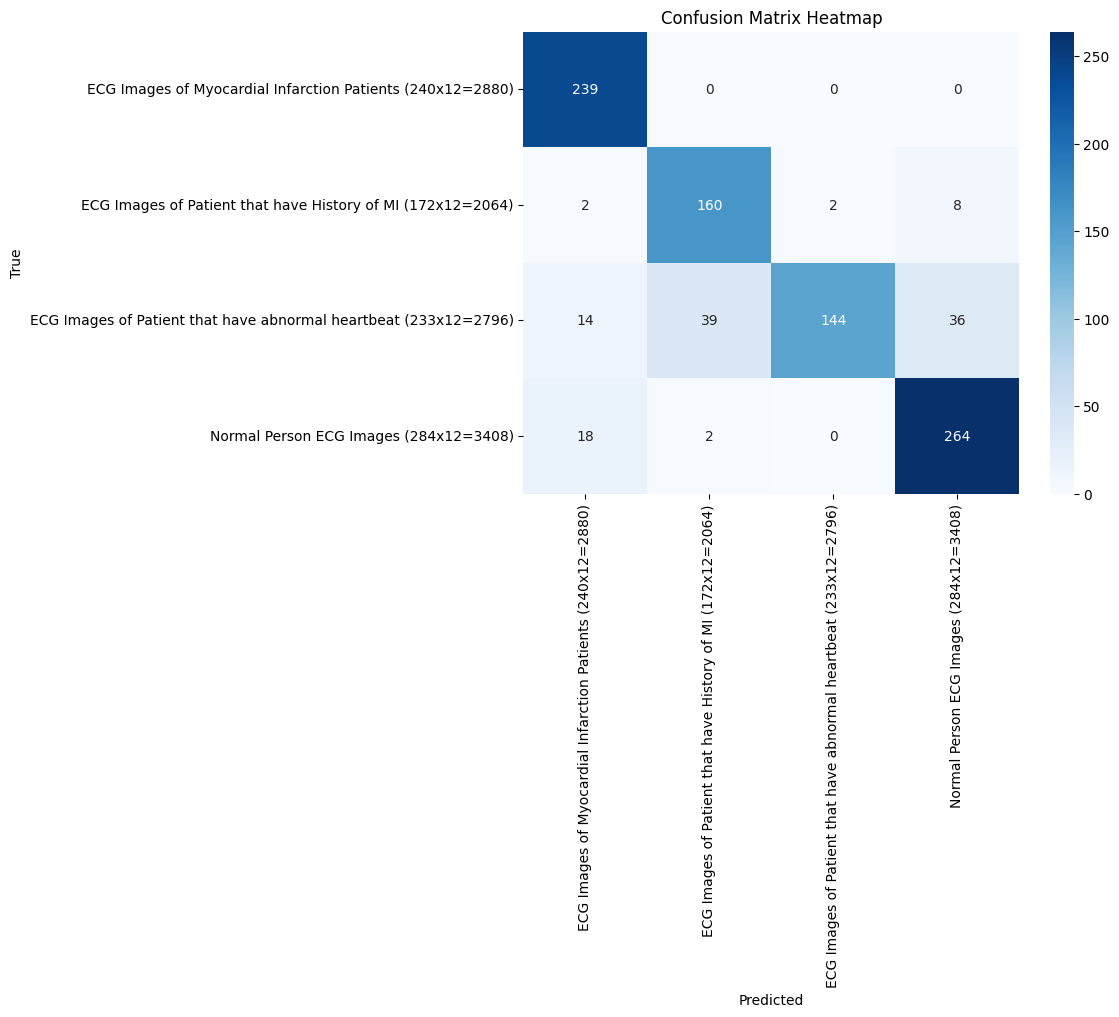

In [8]:
# ==============================
# STEP 6: Evaluate Best Model
# ==============================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

best_model = tf.keras.models.load_model(best_model_path)

# Predict on test set
preds = best_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

# Reports
print("✅ Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_gen.class_indices.keys()),
            yticklabels=list(test_gen.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [9]:
# ==============================
# STEP 7: Detect Arrhythmia on New Image
# ==============================
def predict_ecg(img_path, model, class_indices):
    img = tf.keras.utils.load_img(img_path, target_size=(224,224))
    img_array = tf.keras.utils.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    class_name = list(class_indices.keys())[list(class_indices.values()).index(class_idx)]
    return class_name

# Test on one image
sample_img = test_gen.filepaths[0]
print("🩺 ECG Image:", sample_img)
print("🔍 Predicted:", predict_ecg(sample_img, best_model, test_gen.class_indices))


🩺 ECG Image: /content/data/ECG_DATA/test/ECG Images of Myocardial Infarction Patients (240x12=2880)/MI(1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🔍 Predicted: ECG Images of Myocardial Infarction Patients (240x12=2880)


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
